# Create photoreduction forcing files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import datetime as dt
import pickle

%matplotlib inline

Parameterization for photo reduction:
- Higher sol_flux means stronger photo reduction.
- Background reduction value: 1
- Photo-enhanced reduction value maximum: 58

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

##### Load files

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:])

mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
tmask = tmask[0,:,imin:imax,jmin:jmax]

##### Functions

In [4]:
def load_variables(filename):
    a = nc.Dataset(filename)
    
    sol_flux = np.array(a.variables['iocesflx'][:,0,:,:])     
    
    return sol_flux

In [5]:
def red_rate_calc(year):
    
    imin, imax = 1480, 2180
    jmin, jmax = 160, 800
    
    sol_flux = load_variables(f'/data/brogalla/ANHA12/icemod_ave/ANHA12_EXH006_{year}_monthly.nc')
    max_sol_flux  = sol_flux[:,imin:imax,jmin:jmax].max()
    mean_sol_flux = sol_flux[:,imin:imax,jmin:jmax].mean()
    
#     for i in range(imin,imax):
#         for j in range(jmin,jmax):
#             for month in range(0,12):
#                  if sol_flux[month,i,j] > 50:
#                         sol_flux[month,i,j] = sol_flux[month,i,j]*1.8
    sol_flux[sol_flux > 100] = max_sol_flux
    normalized_solar_flux = np.abs(sol_flux - mean_sol_flux)/max_sol_flux
    
    red_rate = normalized_solar_flux * 58
    
    red_rate[red_rate < 1] = 1
    red_rate[red_rate > 58] = 58
#     red_rate[red_rate 
    
    return red_rate

In [86]:
red_rate_new = red_rate_calc(2002)

(0.0, 0.05)

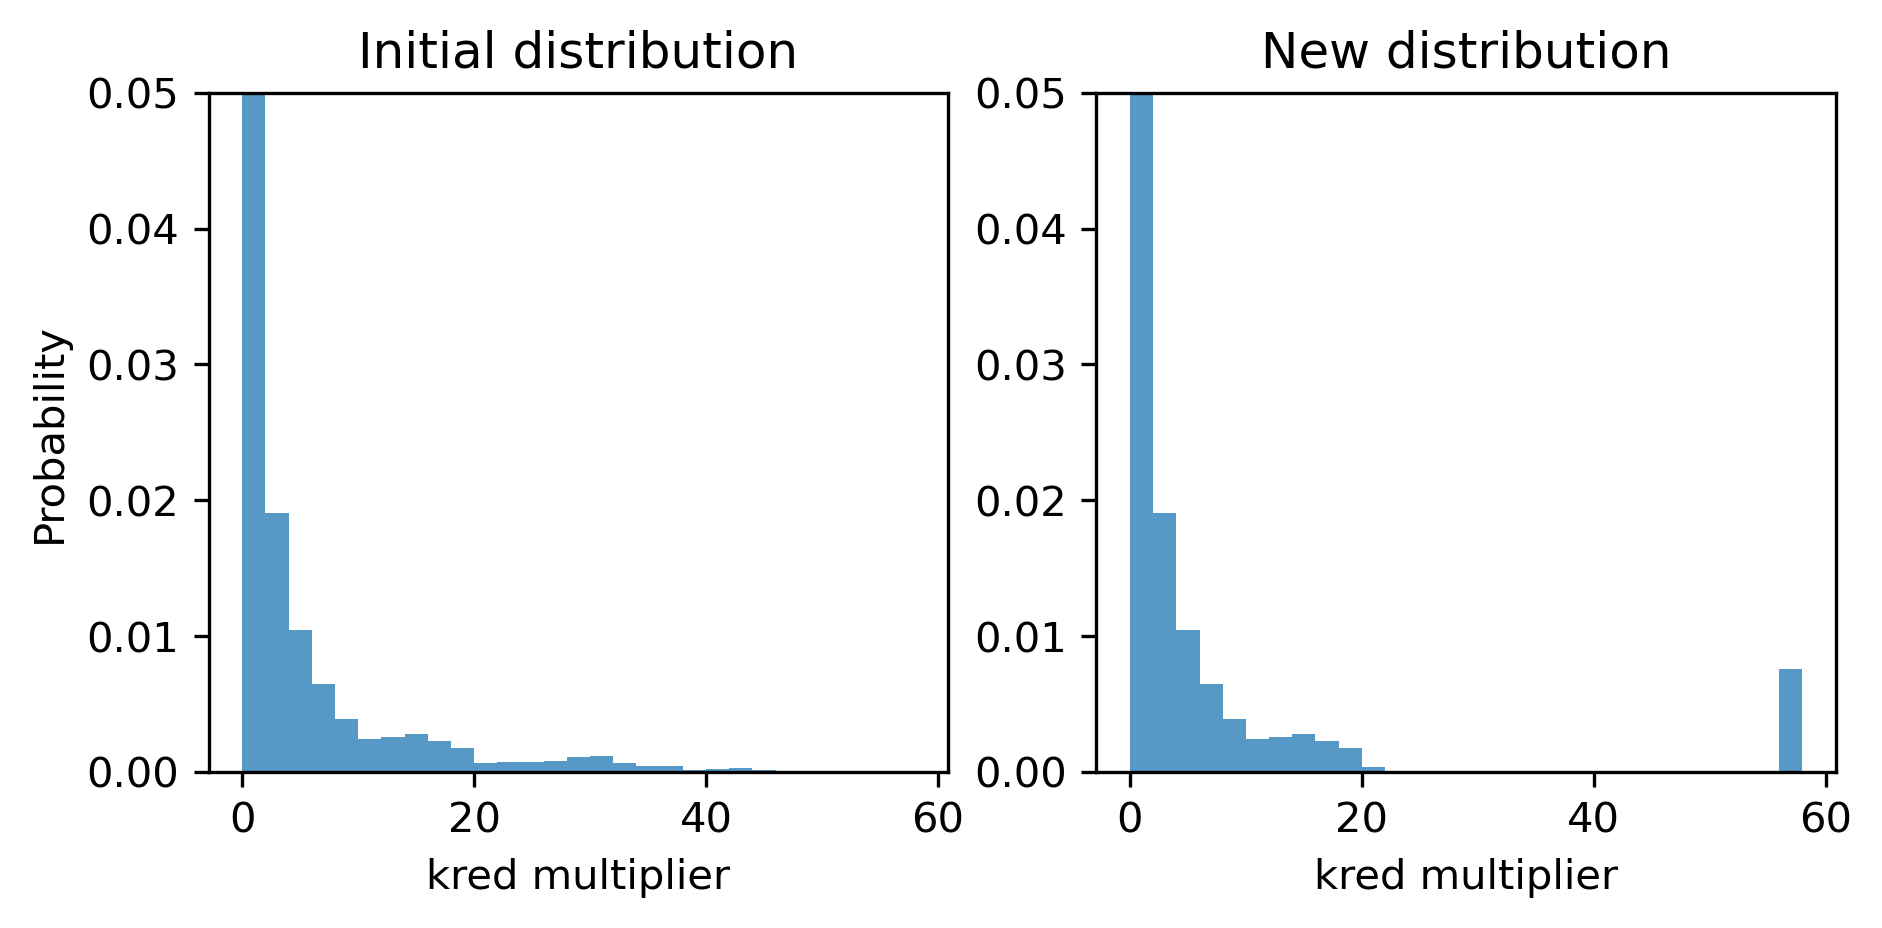

In [87]:
fig, ax = plt.subplots(1,2, figsize=(7,3), dpi=300)

bins=np.arange(0,60,2)
n, bins, patches = ax[0].hist(red_rate_initial[:,imin:imax,jmin:jmax].flatten(), bins=bins, density=True, alpha=0.75)
n, bins, patches = ax[1].hist(red_rate_new[:,imin:imax,jmin:jmax].flatten(), bins=bins, density=True, alpha=0.75)

ax[0].set_title('Initial distribution')
ax[1].set_title('New distribution')
ax[0].set_xlabel('kred multiplier')
ax[1].set_xlabel('kred multiplier')
ax[0].set_ylabel('Probability')

ax[0].set_ylim(0,0.05)
ax[1].set_ylim(0,0.05)

In [89]:
def save_file(filename, field1):
    ncd = nc.Dataset(filename, 'w', zlib=True)

    ncd.createDimension('x',len(mesh.dimensions['x']))
    ncd.createDimension('y',len(mesh.dimensions['y']))
    ncd.createDimension('time_counter',None)
    
    # variables
    red             = ncd.createVariable('kred', 'float64', ('y','x'))
    red.units       = 'Unitless'
    red.long_name   = 'Photoreduction multiplier'  
    red.coordinates = 'nav_lon nav_lat'
    red[:]          = field1[:]

    ncd.close()
    return

In [95]:
def red_year(year, savefile=False):
    
    red_rateyear = red_rate_calc(year)
    
    if savefile:
        location='/data/brogalla/reduction_forcing/20210817/'
        
        for i in range(1,13):
            if i < 10:
                save_file(location+'red_y'+str(year)+'m0'+str(i)+'.nc',red_rateyear[i-1,:,:])
            else:
                save_file(location+'red_y'+str(year)+'m'+str(i)+'.nc',red_rateyear[i-1,:,:])
        
    
    return red_rateyear

##### Calculations

In [96]:
red_rate = red_year(2002, savefile=True)

In [97]:
for year in range(2003,2021):
    red_rate = red_year(year, savefile=True)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/brogalla/ANHA12/icemod_ave/ANHA12_EXH006_2020_monthly.nc'

Read file:

In [9]:
file = nc.Dataset('/data/brogalla/reduction_forcing/red_y2015m08.nc')
kred = np.array(file.variables['kred'])

In [11]:
print(f'CB2: kred is {kred[(507+imin, 383+jmin)]}')
print(f'CB3: kred is {kred[(546+imin, 456+jmin)]}')
print(f'CB4: kred is {kred[(628+imin, 470+jmin)]}')

CB2: kred is 12.324295997619629
CB3: kred is 7.106563091278076
CB4: kred is 4.797695636749268
